# I. Install and load libraries

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import logging
import joblib
from sklearn.metrics import classification_report
from dotenv import load_dotenv
load_dotenv()

True

In [14]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

logger = logging.getLogger()

# II. Downloading dataset 

In [15]:
run = wandb.init(project="diabetes", job_type="test")

In [16]:
WANDB_API_KEY=os.environ.get('WANDB_API_KEY')
!wandb login --relogin $WANDB_API_KEY

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PC\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [17]:
logger.info("Downloading and reading test artifact")

artifact_X_test = wandb.use_artifact('diabetes/X_test.csv:latest', type='preprocessing')
artifact_y_test = wandb.use_artifact('diabetes/y_test.csv:latest', type='preprocessing')

X_test_dir = artifact_X_test.download()
y_test_dir = artifact_y_test.download()

X_test_path = os.path.join(X_test_dir, "X_test.csv")
y_test_path = os.path.join(y_test_dir, "y_test.csv")

X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

06-05-2025 12:26:41 Downloading and reading test artifact
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [18]:
X_test.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,3.0,7.0,0.0,0.0,7.0,4.0,2.0
1,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,6.0,6.0
2,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,7.0
3,0.0,0.0,1.0,27.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,4.0,7.0
4,0.0,1.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,4.0,5.0,7.5,1.0,0.0,8.0,3.0,2.0


# III. Dowloading model 

In [19]:
logger.info("Downloading and load the exported model")
artifact_model_name = "model_export:latest" 
model_artifact = run.use_artifact(artifact_model_name)
model_dir = model_artifact.download()  

model_export_path = os.path.join(model_dir, "model_export")  

pipe = joblib.load(model_export_path)

06-05-2025 12:26:47 Downloading and load the exported model
wandb:   1 of 1 files downloaded.  


# IV. Testing 

In [20]:
logger.info("Infering")
predict = pipe.predict(X_test)

logger.info("Test Evaluation metrics")
fbeta = f1_score(y_test, predict, zero_division=1, average='weighted')
precision = precision_score(y_test, predict, zero_division=1, average='weighted')
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

06-05-2025 12:26:50 Infering
06-05-2025 12:26:50 Test Evaluation metrics
06-05-2025 12:26:50 Test Accuracy: 0.7221302428256071
06-05-2025 12:26:50 Test Precision: 0.8663434708351219
06-05-2025 12:26:50 Test Recall: 0.7960554523367157
06-05-2025 12:26:50 Test F1: 0.7635363680705628


In [21]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     43739
         1.0       0.31      0.80      0.44      6997

    accuracy                           0.72     50736
   macro avg       0.63      0.75      0.63     50736
weighted avg       0.87      0.72      0.76     50736



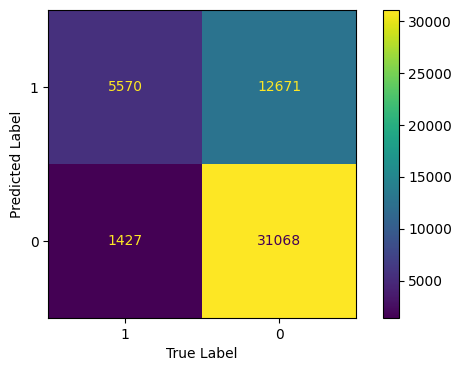

In [22]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=["1","0"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [23]:
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix)
    }
)

06-05-2025 12:26:51 Uploading figures


In [24]:
run.finish()

Accuracy,0.72213
F1,0.76354
Precision,0.86634
Recall,0.79606
